In [1]:
import pandas as pd
import argparse
import random
import time
import os
import duckdb

import sys
sys.path.append(os.path.abspath(os.getcwd()+'/..'))

from config_loc import get_data_folder
from featurelib.lib_v1 import *

con = duckdb.connect(os.path.join(get_data_folder(),"my_database.db"),read_only=True)

g_folder = 'res_exploration_v1'

/Users/sachadrevet/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# clean the steppers cache
os.listdir(os.path.join(get_data_folder,g_folder))

TypeError: expected str, bytes or os.PathLike object, not function

In [3]:
df=con.execute('SELECT close_time,dscode,close,volume,taker_buy_volume FROM klines;').df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
# we need to convert dscode to an integer 
df['dscode_str']=df['dscode'].copy()
df['dscode']=pd.Categorical(df['dscode_str']).codes
df['dtsi'] = df['close_time'].astype('int64')

df.sort_values('close_time',ascending=True,inplace=True)

featd={col: df[col].values for col in df.columns}

In [5]:
## adding returns
featd,nfeats=perform_diff(featd=featd,feats=['close'],windows=[1],folder=g_folder,name='None')
featd['tret']=np.divide(
                featd[nfeats[0]],
                featd['close'],
                out=np.zeros_like(featd['close']),
                where=~np.isclose(featd['close'], np.zeros_like(featd['close'])))


## adding the weight ewm(volume)
featd,nfeats=perform_ewm(featd=featd,feats=['volume'],windows=[1000],folder=g_folder,name='None')
featd['wgt'] = featd[nfeats[0]]

Cannot load the Stepper- will create one


In [6]:
featd.keys()

dict_keys(['close_time', 'dscode', 'close', 'volume', 'taker_buy_volume', 'dscode_str', 'dtsi', 'close_diff1', 'tret', 'volume_ewm1000', 'wgt'])

In [7]:
dft = pd.DataFrame(featd)
pdft=dft.pivot_table(index='close_time',columns='dscode_str',values='tret')

<Axes: xlabel='close_time'>

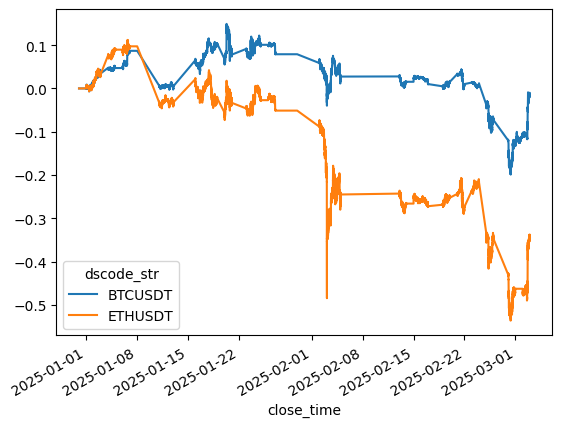

In [8]:
pdft[['BTCUSDT','ETHUSDT']].fillna(0.0).cumsum().plot()